## Configuración de librerías

In [1]:
import os
import gc
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torchvision.models.resnet import ResNet18_Weights
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
#!pip install -q torchsummary --user
from torchsummary import summary

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Si tenemos disponible GPU, lo usamos
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


Establecemos una semilla aleatoria para fines de reproducibilidad.

In [3]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101);

## Exploración de datos

#### Distribución de Etiquetas
Primero carguemos el conjunto de datos de entrenamiento y cuantifiquemos la distribución de las etiquetas.

In [4]:
path = "../data"
path_train = os.path.join(path, "train")
path_test = os.path.join(path, "test")
path_valid = os.path.join(path, "valid")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}, "
    f"valid files: {len(os.listdir(path_valid))}"
)

train files: 11466, test files: 546, valid files: 1092


In [5]:
path_train_class = os.path.join(path, "train_classes.csv")
df_train = pd.read_csv(path_train_class)
print(df_train.shape)
df_train.head()

(11466, 43)


,filename,Aerosols,Aluminum can,Aluminum caps,Cardboard,Cellulose,Ceramic,Combined plastic,Container for household chemicals,Disposable tableware,...,Postal packaging,Printing industry,Scrap metal,Stretch film,Tetra pack,Textile,Tin,Unknown plastic,Wood,Zip plastic bag
0,2ccff6c6-AluCan257_jpg.rf.a8f53f21395d0d5757d7...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,afe7846c-AluCan477_jpg.rf.a91f8c8b95877f244426...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,054a27ce-O_13607_jpg.rf.a9244c990c852cd6911168...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9c2713f8-R_817_jpg.rf.a9900435405fc7a9d162fb47...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,59b34896-R_2091_jpg.rf.a967d601319609446bd2cd5...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
path_test_class = os.path.join(path, "test_classes.csv")
df_test = pd.read_csv(path_test_class)
print(df_test.shape)
df_test.head()

(546, 43)


,filename,Aerosols,Aluminum can,Aluminum caps,Cardboard,Cellulose,Ceramic,Combined plastic,Container for household chemicals,Disposable tableware,...,Postal packaging,Printing industry,Scrap metal,Stretch film,Tetra pack,Textile,Tin,Unknown plastic,Wood,Zip plastic bag
0,8f348f9f-O_13536_jpg.rf.08634df680810bca2b4a6a...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3f788eca-R_1233_jpg.rf.009b5c0202d6119a0acca8c...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6a20eaff-AluCan799_jpg.rf.01285186bbe2fda2eca0...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8581d82d-R_2095_jpg.rf.04ef30447681b847ad657b2...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8979cf11-R_2467_jpg.rf.02a569d2d0a85fee2236b08...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
path_valid_class = os.path.join(path, "valid_classes.csv")
df_valid = pd.read_csv(path_valid_class)
print(df_valid.shape)
df_valid.head()

(1092, 43)


,filename,Aerosols,Aluminum can,Aluminum caps,Cardboard,Cellulose,Ceramic,Combined plastic,Container for household chemicals,Disposable tableware,...,Postal packaging,Printing industry,Scrap metal,Stretch film,Tetra pack,Textile,Tin,Unknown plastic,Wood,Zip plastic bag
0,2b03f9aa-R_4195_jpg.rf.005f4da2f54ffac923adcd3...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,70365097-R_3945_jpg.rf.00ab5b40189e5df4c509b1d...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cc49670e-O_13864_jpg.rf.00c0e6fc21e3153c1a3aae...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,e0fecbfa-R_1369_jpg.rf.01aa09b57e1ed312419e5bc...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,8725f984-R_2175_jpg.rf.0187475cc88c9fb7f68deff...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Veremos si hay columnas que no poseen en ninguna fila al menos un 1.

In [8]:
# Voy a ver si hay columnas que no contienen ningún valor 1, y por lo tanto no aportan información
# Entrenamiento
columnas_sin_unos_train = df_train.columns[(df_train == 1).sum() == 0]

print("-- Dataset de entrenamiento --")
print("Columnas que no contienen ningún valor 1:")
print(columnas_sin_unos_train)

-- Dataset de entrenamiento --
Columnas que no contienen ningún valor 1:
Index(['filename', ' Aluminum caps', ' Combined plastic', ' Foil',
       ' Iron utensils', ' Metal shavings', ' Wood'],
      dtype='object')


In [9]:
# Voy a ver si hay columnas que no contienen ningún valor 1, y por lo tanto no aportan información
# Test
columnas_sin_unos_test = df_test.columns[(df_test == 1).sum() == 0]

print("-- Dataset de entrenamiento --")
print("Columnas que no contienen ningún valor 1:")
print(columnas_sin_unos_test)

-- Dataset de entrenamiento --
Columnas que no contienen ningún valor 1:
Index(['filename', ' Aluminum caps', ' Cellulose', ' Ceramic',
       ' Combined plastic', ' Furniture', ' Iron utensils', ' Liquid',
       ' Metal shavings', ' Milk bottle', ' Paper cups', ' Paper shavings',
       ' Papier mache', ' Plastic caps', ' Plastic toys', ' Scrap metal',
       ' Stretch film', ' Wood'],
      dtype='object')


In [10]:
# Voy a ver si hay columnas que no contienen ningún valor 1, y por lo tanto no aportan información
# Validación
columnas_sin_unos_valid = df_valid.columns[(df_valid == 1).sum() == 0]

print("-- Dataset de entrenamiento --")
print("Columnas que no contienen ningún valor 1:")
print(columnas_sin_unos_valid)

-- Dataset de entrenamiento --
Columnas que no contienen ningún valor 1:
Index(['filename', ' Cellulose', ' Ceramic', ' Disposable tableware',
       ' Electronics', ' Foil', ' Furniture', ' Paper cups', ' Plastic can',
       ' Plastic caps', ' Plastic toys', ' Scrap metal', ' Stretch film'],
      dtype='object')


#### Eliminamos las columnas con valores nulos.

In [11]:
# Del dataset de entrenamiento, test y validacion 
#, elimino las columnas que no contienen ningún valor 1
columnas_a_eliminar = [col for col in columnas_sin_unos_train if col != 'filename']
df_train = df_train.drop(columns=columnas_a_eliminar)

columnas_a_eliminar = [col for col in columnas_sin_unos_test if col != 'filename']
df_test = df_test.drop(columns=columnas_a_eliminar)

columnas_a_eliminar = [col for col in columnas_sin_unos_valid if col != 'filename']
df_valid = df_valid.drop(columns=columnas_a_eliminar)


In [12]:
df_train.shape

(11466, 37)

In [13]:
df_test.shape

(546, 26)

In [14]:
df_valid.shape

(1092, 31)

In [15]:
df_valid.head()

,filename,Aerosols,Aluminum can,Aluminum caps,Cardboard,Combined plastic,Container for household chemicals,Glass bottle,Iron utensils,Liquid,...,Plastic shaker,Plastic shavings,Postal packaging,Printing industry,Tetra pack,Textile,Tin,Unknown plastic,Wood,Zip plastic bag
0,2b03f9aa-R_4195_jpg.rf.005f4da2f54ffac923adcd3...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,70365097-R_3945_jpg.rf.00ab5b40189e5df4c509b1d...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cc49670e-O_13864_jpg.rf.00c0e6fc21e3153c1a3aae...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,e0fecbfa-R_1369_jpg.rf.01aa09b57e1ed312419e5bc...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8725f984-R_2175_jpg.rf.0187475cc88c9fb7f68deff...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train_columnas = set(df_train.columns[1:])
test_columnas = set(df_test.columns[1:])
valid_columnas = set(df_valid.columns[1:])


In [17]:
# Verificar si todas las columnas del test están en el entrenamiento
test_in_train = test_columnas.issubset(train_columnas)
print(f"¿Todas las columnas del test están en el entrenamiento? {test_in_train}")
valid_in_train = valid_columnas.issubset(train_columnas)
print(f"¿Todas las columnas de validación están en el entrenamiento? {valid_in_train}")

¿Todas las columnas del test están en el entrenamiento? False
¿Todas las columnas de validación están en el entrenamiento? False


In [18]:
# Identificar columnas faltantes
missing_in_train_from_test = test_columnas - train_columnas
missing_in_train_from_val = valid_columnas - train_columnas

print(f'Columnas en test pero no en entrenamiento: {missing_in_train_from_test}')
print(f'Columnas en validación pero no en entrenamiento: {missing_in_train_from_val}')


Columnas en test pero no en entrenamiento: {' Foil'}
Columnas en validación pero no en entrenamiento: {' Wood', ' Aluminum caps', ' Metal shavings', ' Combined plastic', ' Iron utensils'}


> Con esto vemos que:

    - en test tenemos la etiqueta ' Foil' que no está en el dataset de entrenamiento.
    - en validación las etiquetas ' Wood', ' Metal shavings', ' Combined plastic', ' Iron utensils', ' Aluminum caps' no están en el dataset de entrenamiento.

> Debemos decidir que hacer. Lo que considero, es descartar el dataset de test que tiene 546 imágenes y el dataset valid que tiene 1092 imágenes. Y usar el dataset de entrenamiento y dividirlo en entrenamiento, test y validación.


### Veamos ahora si hay imágenes que no tienen asignada ninguna categoría

In [19]:
# Voy a ver si hay imágenes que no tienen asignada ninguna categoría en el dataset de entrenamiento

# Definir las columnas de categorías (excluyendo la columna 'filename')
categorias = df_train.columns[1:]

# Filtrar las filas donde todas las columnas de categorías son 0
sin_categoria = df_train[categorias].sum(axis=1) == 0

# Obtener las imágenes que no tienen asignada ninguna categoría
imagenes_sin_categoria = df_train[sin_categoria]

# Mostrar las imágenes sin categoría
print("ENTRENAMIENTO: Imágenes sin ninguna categoría asignada:")
print(imagenes_sin_categoria['filename'])


ENTRENAMIENTO: Imágenes sin ninguna categoría asignada:
Series([], Name: filename, dtype: object)


In [20]:
# Ahora voy a ver si hay imágenes que no tienen asignada ninguna categoría en el dataset de test

# Definir las columnas de categorías (excluyendo la columna 'filename')
categorias = df_test.columns[1:]

# Filtrar las filas donde todas las columnas de categorías son 0
sin_categoria = df_test[categorias].sum(axis=1) == 0

# Obtener las imágenes que no tienen asignada ninguna categoría
imagenes_sin_categoria = df_test[sin_categoria]

# Mostrar las imágenes sin categoría
print("TEST: Imágenes sin ninguna categoría asignada:")
print(imagenes_sin_categoria['filename'])


TEST: Imágenes sin ninguna categoría asignada:
Series([], Name: filename, dtype: object)


In [21]:
# Ahora voy a ver si hay imágenes que no tienen asignada ninguna categoría en el dataset de validación

# Definir las columnas de categorías (excluyendo la columna 'filename')
categorias = df_valid.columns[1:]

# Filtrar las filas donde todas las columnas de categorías son 0
sin_categoria = df_valid[categorias].sum(axis=1) == 0

# Obtener las imágenes que no tienen asignada ninguna categoría
imagenes_sin_categoria = df_valid[sin_categoria]

# Mostrar las imágenes sin categoría
print("VALIDACION: Imágenes sin ninguna categoría asignada:")
print(imagenes_sin_categoria['filename'])

VALIDACION: Imágenes sin ninguna categoría asignada:
Series([], Name: filename, dtype: object)


## Veamos la distribución de etiquetas en cada dataset

In [22]:
# Extraigo las columnas de cada dataset a partir de la segunda columna hasta la última
train_etiquetas = df_train.columns[1:]
test_etiquetas = df_test.columns[1:]
valid_etiquetas = df_valid.columns[1:]

In [23]:
# Imprimo la cantidad de etiquetas en cada dataset
print(
    f"train etiquetas: {len(train_etiquetas)}, "
    f"test etiquetas: {len(test_etiquetas)}, "
    f"valid etiquetas: {len(valid_etiquetas)}"
)

train etiquetas: 36, test etiquetas: 25, valid etiquetas: 30


In [24]:
# Grafico la cantidad de veces que aparece cada etiqueta en el dataset de entrenamiento ordenadas de mayor a menor
etiquetas = df_train[train_etiquetas].sum().sort_values(ascending=False)

# Crear el gráfico de barras
fig = px.bar(
    x=etiquetas.index, 
    y=etiquetas.values, 
    title="Dataset Entrenamiento: Cantidad de imágenes por etiqueta",
    labels={'x': 'Etiqueta', 'y': 'Cantidad de Imágenes'},
    height=600  # Ajusta esta altura según tus necesidades
)

# Añadir anotaciones con el número total de imágenes en cada barra
fig.update_traces(text=etiquetas.values, textposition='outside')

# Ajustar el orden de las categorías en el eje x
fig.update_xaxes(categoryorder="total descending")

# Mostrar el gráfico
fig.show()

In [25]:
# Grafico la cantidad de veces que aparece cada etiqueta en el dataset de test ordenadas de mayor a menor
etiquetas = df_test[test_etiquetas].sum().sort_values(ascending=False)

# Crear el gráfico de barras
fig = px.bar(
    x=etiquetas.index, 
    y=etiquetas.values, 
    title="Dataset Test: Cantidad de imágenes por etiqueta",
    labels={'x': 'Etiqueta', 'y': 'Cantidad de Imágenes'},
    height=600  # Ajusta esta altura según tus necesidades
)

# Añadir anotaciones con el número total de imágenes en cada barra
fig.update_traces(text=etiquetas.values, textposition='outside')

# Ajustar el orden de las categorías en el eje x
fig.update_xaxes(categoryorder="total descending")

# Mostrar el gráfico
fig.show()

In [26]:
# Grafico la cantidad de veces que aparece cada etiqueta en el dataset de validacion ordenadas de mayor a menor
etiquetas = df_valid[valid_etiquetas].sum().sort_values(ascending=False)

# Crear el gráfico de barras
fig = px.bar(
    x=etiquetas.index, 
    y=etiquetas.values, 
    title="Dataset Validación: Cantidad de imágenes por etiqueta",
    labels={'x': 'Etiqueta', 'y': 'Cantidad de Imágenes'},
    height=600  # Ajusta esta altura según tus necesidades
)

# Añadir anotaciones con el número total de imágenes en cada barra
fig.update_traces(text=etiquetas.values, textposition='outside')

# Ajustar el orden de las categorías en el eje x
fig.update_xaxes(categoryorder="total descending")

# Mostrar el gráfico
fig.show()


## Veamos ahora la cantidad de imágenes con más de una etiqueta

In [27]:
# Determinar la cantidad de filas que tienen más de una etiqueta
train_multietiquetas = df_train[train_etiquetas].sum(axis=1)
test_multietiquetas = df_test[test_etiquetas].sum(axis=1)
valid_multietiquetas = df_valid[valid_etiquetas].sum(axis=1)

# Crear el gráfico con Plotly
fig = go.Figure()

# Añadir los histogramas para cada conjunto de datos
fig.add_trace(go.Histogram(
    x=train_multietiquetas,
    name="train",
    texttemplate="%{y}", # Plantilla para mostrar valores
    textposition="outside" # Posición del texto
))

fig.add_trace(go.Histogram(
    x=test_multietiquetas,
    name="test",
    texttemplate="%{y}",
    textposition="outside"
))

fig.add_trace(go.Histogram(
    x=valid_multietiquetas,
    name="valid",
    texttemplate="%{y}",
    textposition="outside"
))

# Actualizar el layout del gráfico
fig.update_layout(
    title="Cantidad de imágenes con más de una etiqueta",
    xaxis_title="Número de etiquetas",
    yaxis_title="Cantidad de imágenes",
    barmode="group", # Agrupar las barras por categoría
    bargap=0.2, # Ajustar la separación entre barras
)

# Mostrar el gráfico
fig.show()


## Veamos si posee una distribución de Pareto

In [28]:
#del df_train
# Forzar la recolección de basura
#gc.collect()

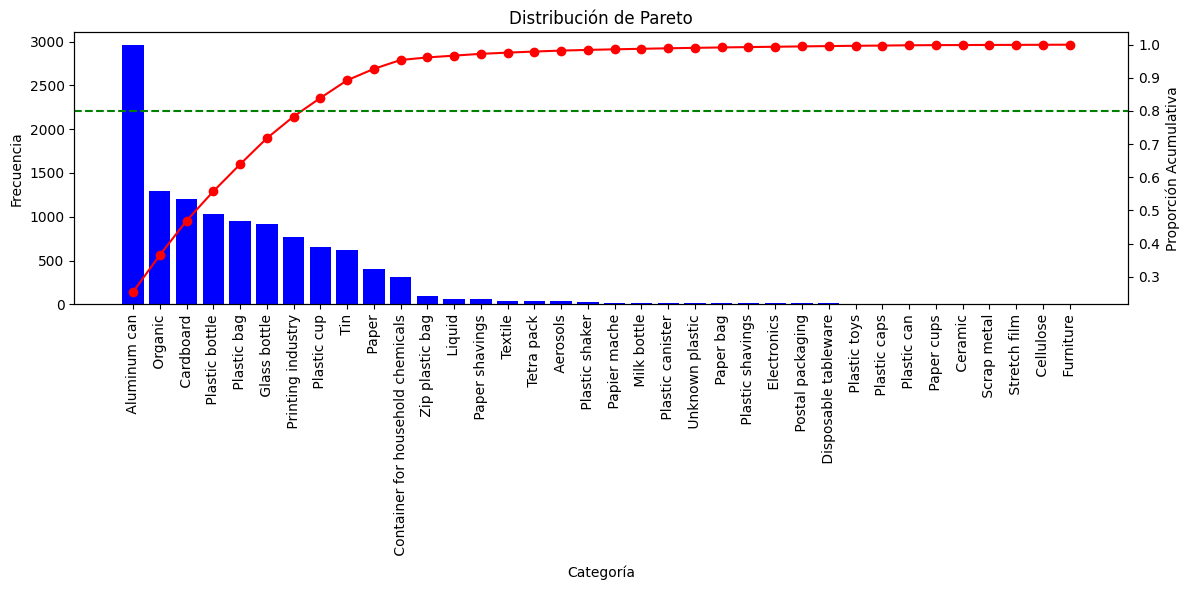

In [29]:
# Determino si posee una distribución de pareto o no en el dataset de entrenamiento

# Calculo la frecuencia de cada categoría (excluyendo la columna de filenames)
category_frequencies = df_train.iloc[:, 1:].sum().sort_values(ascending=False)

# Calcular la proporción acumulativa
cumulative_proportion = category_frequencies.cumsum() / category_frequencies.sum()

# Crear el gráfico de Pareto
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(category_frequencies.index, category_frequencies, color='blue')
ax2 = ax.twinx()
ax2.plot(category_frequencies.index, cumulative_proportion, color='red', marker='o', linestyle='-')

# Añadir una línea horizontal en el 80%
ax2.axhline(y=0.8, color='green', linestyle='--')

# Añadir etiquetas y título
ax.set_xlabel('Categoría')
ax.set_ylabel('Frecuencia')
ax2.set_ylabel('Proporción Acumulativa')
plt.title('Distribución de Pareto')

# Rotar etiquetas del eje x
ax.set_xticks(range(len(category_frequencies.index)))
ax.set_xticklabels(category_frequencies.index, rotation=90)

# Mostrar el gráfico
plt.tight_layout()
plt.show()



In [30]:
# Determino que clases son las que llegan al 80% de las imágenes
etiquetas_en_80 = cumulative_proportion[cumulative_proportion <= 0.8].index
etiquetas_en_80

Index([' Aluminum can', ' Organic', ' Cardboard', ' Plastic bottle',
       ' Plastic bag', ' Glass bottle', ' Printing industry'],
      dtype='object')

In [31]:
# Ahora determino que clases son las que no llegan al 80% de las imágenes
etiquetas_no_80 = cumulative_proportion[cumulative_proportion > 0.8].index
etiquetas_no_80

Index([' Plastic cup', ' Tin', ' Paper', ' Container for household chemicals',
       ' Zip plastic bag', ' Liquid', ' Paper shavings', ' Textile',
       ' Tetra pack', ' Aerosols', ' Plastic shaker', ' Papier mache',
       ' Milk bottle', ' Plastic canister', ' Unknown plastic', ' Paper bag',
       ' Plastic shavings', ' Electronics', ' Postal packaging',
       ' Disposable tableware', ' Plastic toys', ' Plastic caps',
       ' Plastic can', ' Paper cups', ' Ceramic', ' Scrap metal',
       ' Stretch film', ' Cellulose', ' Furniture'],
      dtype='object')

Como podemos ver, el dataset tiene una distribución de Pareto.
El analisis indica que algunas clases estan ampliamente representadas mientras que otras apenas están presentes en este conjuneto de datos, siguiendo una distribución de Pareto. O sea que existe un riesgo importante que nuestro modelo apenas aprenda las clases raras o incluso las excluya de los datos de entrenamiento. Con los conjuntos de datos de test y validación pasa lo mismo, responden a una distribución de Pareto. 

> El tema es que nos encontramos con la pregunta: ¿Que estrategias deberiamos tomar con las clases raras para que sean mejor tomadas o tratadas?

1. Recolectar datos adicionales. 
2. Rebalanceo de datos (sub-muestreo o sobre-muestreo)
3. Data augmentation
4. Ajuste de ponderaciones (Class Weighting)
5. Estratificación de datos
6. Métricas de evaluación adecuada

Consideramos emplear la estrategia 3 y la 6.



In [32]:
# Convierto en lista las etiquetas que no llegan al 80% de las imágenes
etiquetas_no_80 = etiquetas_no_80.tolist()

In [33]:
print(f"etiquetas_no_80: {etiquetas_no_80}")

etiquetas_no_80: [' Plastic cup', ' Tin', ' Paper', ' Container for household chemicals', ' Zip plastic bag', ' Liquid', ' Paper shavings', ' Textile', ' Tetra pack', ' Aerosols', ' Plastic shaker', ' Papier mache', ' Milk bottle', ' Plastic canister', ' Unknown plastic', ' Paper bag', ' Plastic shavings', ' Electronics', ' Postal packaging', ' Disposable tableware', ' Plastic toys', ' Plastic caps', ' Plastic can', ' Paper cups', ' Ceramic', ' Scrap metal', ' Stretch film', ' Cellulose', ' Furniture']


## Visualización de clases

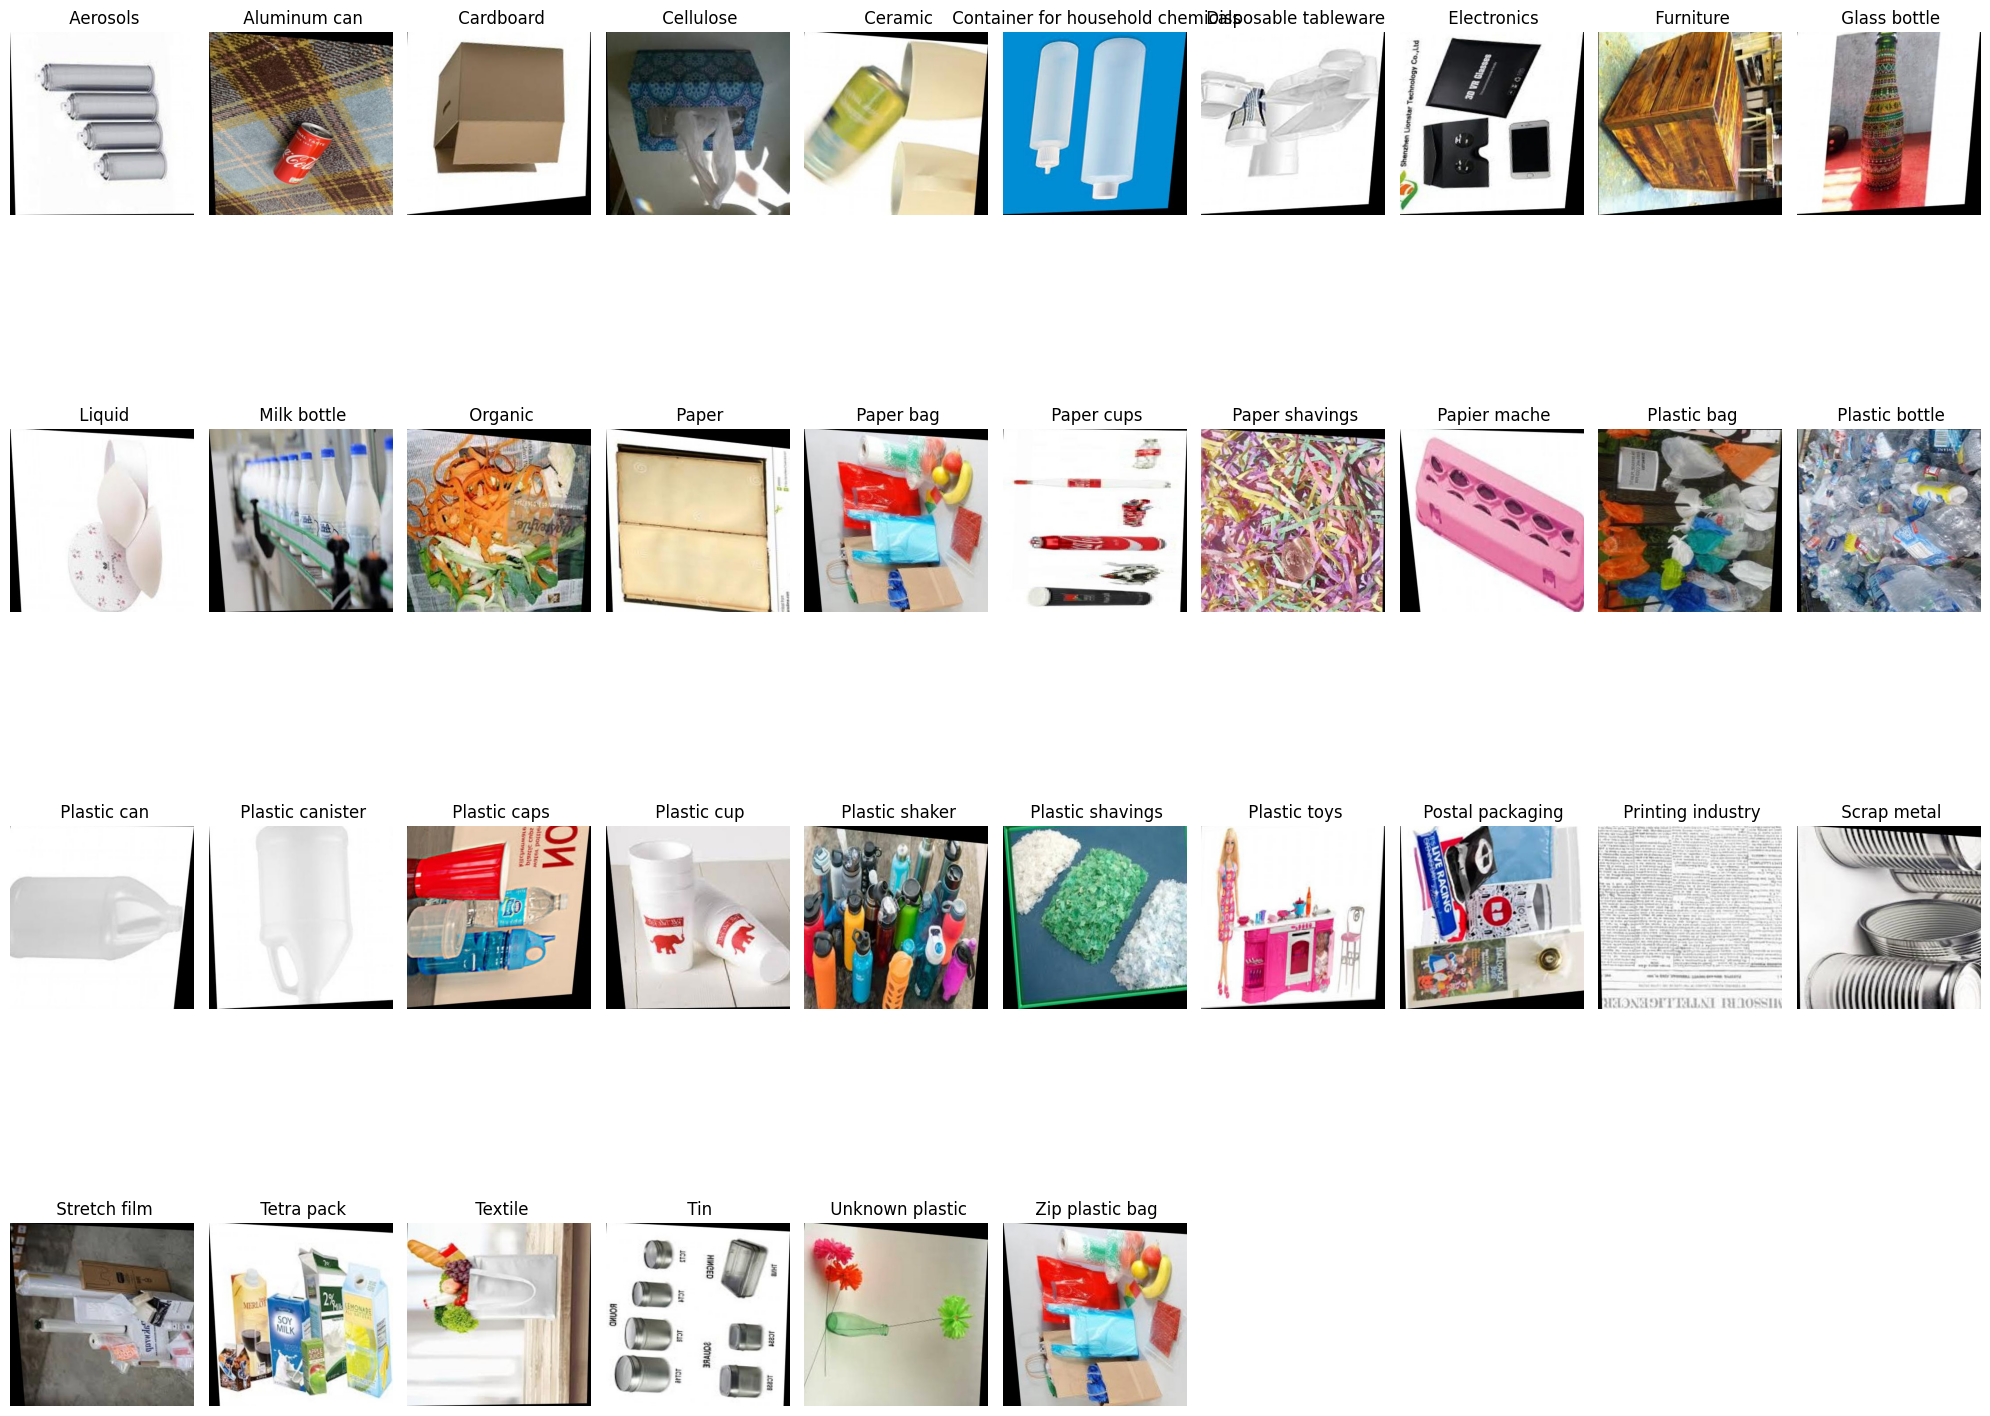

In [34]:
todas_las_etiquetas = df_train.columns[1:].tolist()
nro_etiquetas = len(todas_las_etiquetas)

fig, axes = plt.subplots(5, (nro_etiquetas // 4) + 1, figsize=(20, 20))
axes = axes.flatten()

for idx, tag in enumerate(todas_las_etiquetas):
   
    filtro = df_train.iloc[:, idx+1] == 1
    filenames = df_train.loc[filtro].filename.values
    
    if len(filenames) > 0:
        filename = filenames[0]  # Usar la primera imagen disponible para cada etiqueta
        img = cv2.imread(os.path.join(path_train, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].set_title(tag)
            axes[idx].imshow(img)
            axes[idx].axis('off')
        else:
            print(f"Error al cargar la imagen {filename}")
    else:
        print(f"No se encontraron imágenes para la etiqueta {tag}")
        print(f"idx: {idx+1}")

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Ajustar espacios entre subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.tight_layout()
plt.show()


## T-SNE y reducción de dimensiones para visualización

- T-SNE nos permite agrupar nuestro conjunto de datos reduciendo las dimensiones de la imagen a solo 2. 

- Es útil para una visualización rápida de nuestro conjunto de datos.

Convertiremos cada imagen en un vector 1D normalizado que podamos superponer entre sí. Esta matriz será la entrada de nuestro TSNE.

In [35]:

def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img


In [36]:
filenames = df_train.filename.sample(600).values
path_files = [os.path.join(path_train, filename) for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [37]:
tsne = TSNE(
    n_components=2,
    init="random",
    random_state=101,
    method="barnes_hut",
    n_iter=500,
    verbose=2,
)
X_embedded = tsne.fit_transform(X_train_sample)
X_embedded.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.005s...
[t-SNE] Computed neighbors for 600 samples in 0.247s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 16.079424
[t-SNE] Computed conditional probabilities in 0.011s
[t-SNE] Iteration 50: error = 62.2302742, gradient norm = 0.1007222 (50 iterations in 0.032s)
[t-SNE] Iteration 100: error = 61.5417595, gradient norm = 0.0840801 (50 iterations in 0.030s)
[t-SNE] Iteration 150: error = 61.6727180, gradient norm = 0.1328262 (50 iterations in 0.030s)
[t-SNE] Iteration 200: error = 61.4159279, gradient norm = 0.1156682 (50 iterations in 0.030s)
[t-SNE] Iteration 250: error = 61.0226936, gradient norm = 0.1359199 (50 iterations in 0.030s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.022694
[t-SNE] Iteration 300: error = 1.1991793, gradient norm = 0.0074966 (50 iterations in 0.031s)
[t-SNE] Iteration 350: error = 1.1420746, gradient norm = 0.0063584 

(600, 2)

In [38]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

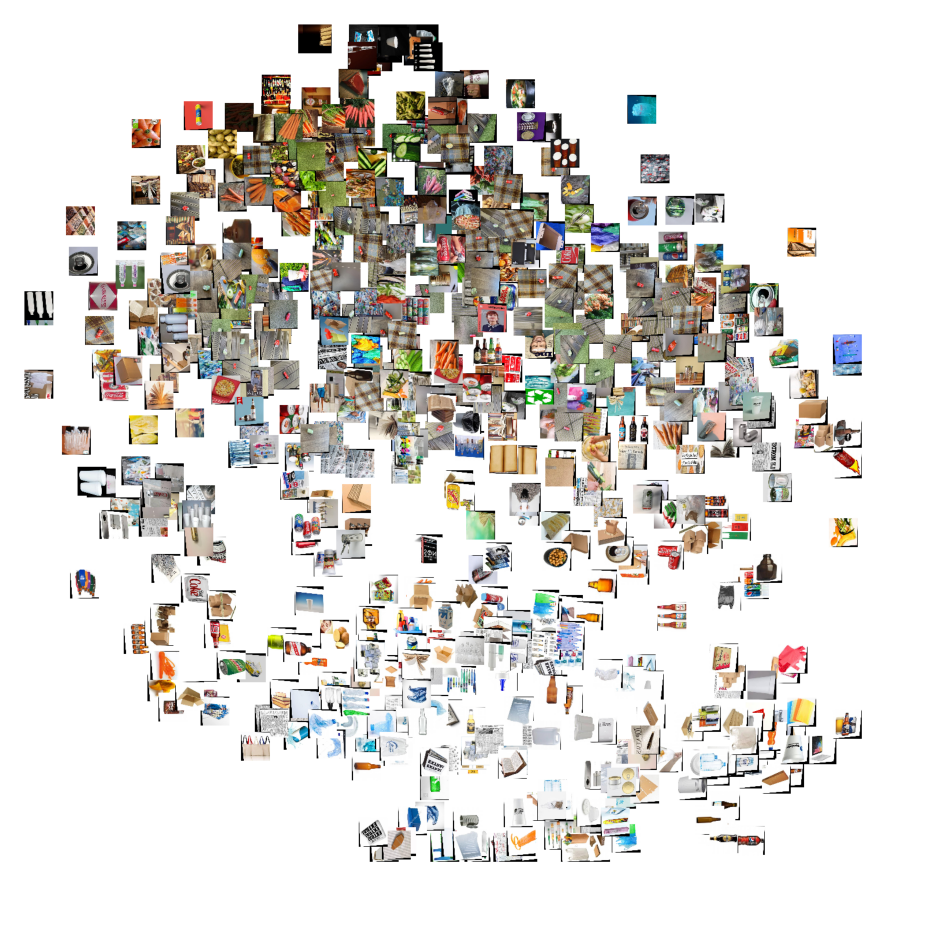

In [41]:
size_img = 1500
offset_img = 50
h = w = int(offset_img / 2)

X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
X_scaled = (X_scaled * size_img).astype(int)
X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

img_tsne = np.ones((size_img+2*offset_img, size_img+2*offset_img, 3), dtype=np.uint8) * 255
for idx in range(X_scaled.shape[0]):
    x, y = X_scaled[idx][0], X_scaled[idx][1]
    img = fetch_img(path_files[idx], h, w)
    img_tsne[x-w:x+w, y-h:y+h, :] = img

fig = plt.figure(figsize=(12, 12))
plt.imshow(img_tsne);
plt.axis("off");

## Modelo

In [42]:
#TODO: Implementar lo demas.